# Fake News Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/fake_or_real_news.csv")
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


# Check for Nulls and Dupes

In [4]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
Dupe Count: 0


In [22]:
df.drop(['title','Unnamed: 0'], inplace=True, axis=1)

Class=FAKE, Count=3164, Percentage=49.945%
Class=REAL, Count=3171, Percentage=50.055%


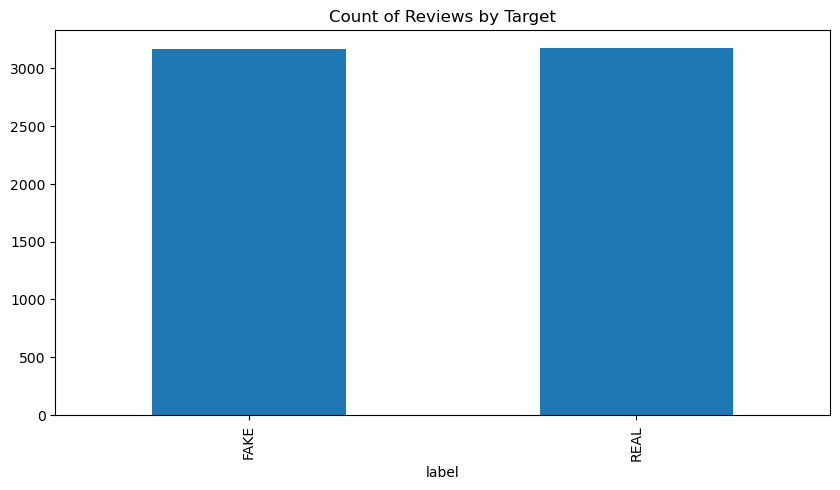

In [24]:
check_class_imbalance(df,df['label'], 'label')

In [25]:

df['len_text'] = df['text'].apply(lambda x: len(x))
df['num_words'] = df['text'].apply(lambda x: len(x.split())) 

In [27]:
df

,text,label,len_text,num_words
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518,1296
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646,446
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543,431
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660,404
4,It's primary day in New York and front-runners...,REAL,1840,317
...,...,...,...,...
6330,The State Department told the Republican Natio...,REAL,4076,642
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,14323,2183
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,11974,1947
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL,6991,1120


# Visuals

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_4081/2158002453.py:5: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Linear')


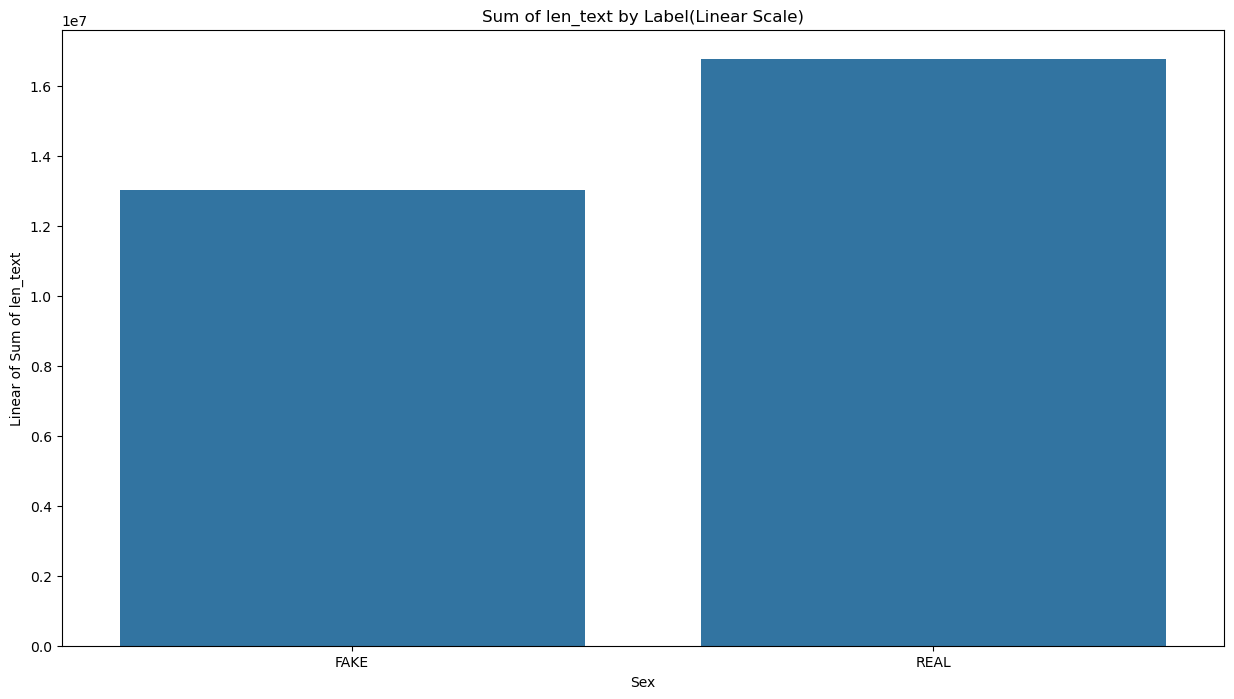

In [36]:
len_text_summary = df.groupby('label')['len_text'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=len_text_summary, x='label', y='len_text')
plt.yscale('Linear')
plt.title('Sum of len_text by Label(Linear Scale)')
plt.xlabel('Sex')
plt.ylabel('Linear of Sum of len_text')
plt.show()

# Real texts seem to be marked as longer

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_4081/1622821370.py:5: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Linear')


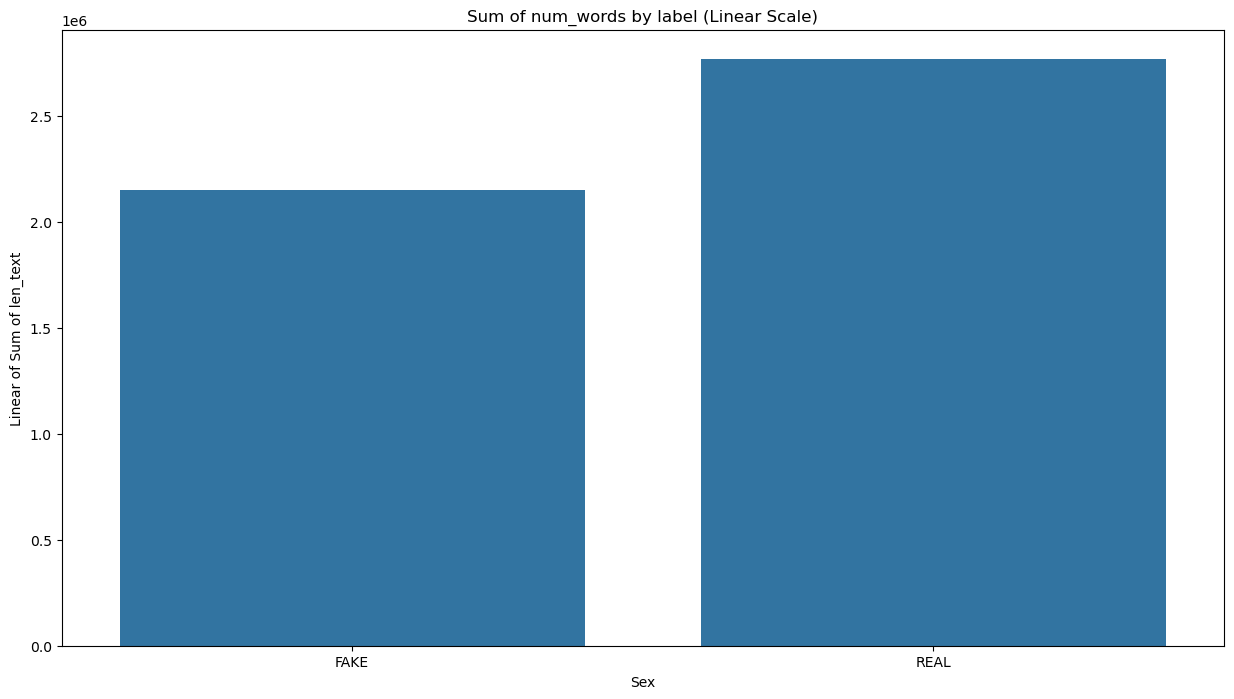

In [35]:
num_words_summary = df.groupby('label')['num_words'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=num_words_summary, x='label', y='num_words')
plt.yscale('Linear')
plt.title('Sum of num_words by label (Linear Scale)')
plt.xlabel('Sex')
plt.ylabel('Linear of Sum of len_text')
plt.show()

In [38]:
df['label'] = df['label'].apply(lambda x: 0 if x =='REAL' else 1)

# Feature Variables

In [39]:
X,y = df['text'], df['label']

# Bert Model

In [40]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')

In [41]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [ ]:
df['text_embeddings'] = df['text'].apply(lambda x: get_embeddings(x))

features = np.array(df['text_embeddings'].tolist()).reshape(df.shape[0], -1)

# Baseline Model Performance

In [ ]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform',) 

scores = evaluate_model(tfidf_fit, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))